# Calculating historical returns on Interest Rate Swaps

#### by Gustavo Soares

In this notebook you will apply a few things you learned in our Python lecture [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, date variables, floats, dictionaries, lists, list comprehensions, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements and loops, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a Bloomberg terminal. If you are using this notebook within BQNT, you may want to use BQL for getting the data.

## Swaps and zero curves

As we discussed previously, the swaps *curve* is a chart that depicts the IRS maturity $T$ on the x-axis and the prevailing fixed rate of the IRS, $r_{T}$ while the *zero curve* imaps interest rates on zero-coupon bonds to different maturities.

Let's now import [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from Bloomberg and show the plain-vanilla semi-annual 30/360 vs. 3M Libor curve swaps curve as well as its zero coupon curve bootstrapped by Bloomberg. Before you do that you need to make sure that the directory where you placed the FinanceHub project is in the python's root directory!

<Figure size 432x288 with 0 Axes>

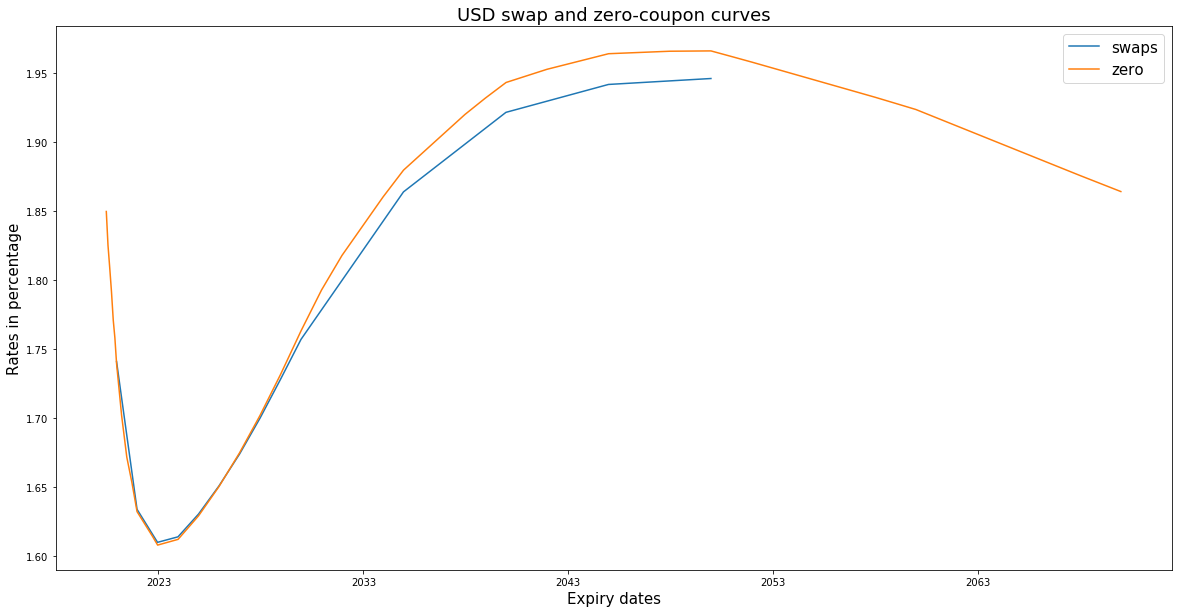

In [1]:
import pandas as pd
from bloomberg import BBG
import matplotlib.pyplot as plt
%matplotlib inline

bbg = BBG()

# list with the Bloomberg tickers for the zero-coupon curve used in projecting the floating leg
tickers_zero_curve = ['S0023Z 1Y BLC2 Curncy',
                      'S0023Z 3M BLC2 Curncy',
                      'S0023Z 10Y BLC2 Curncy',
                      'S0023Z 1M BLC2 Curncy',
                      'S0023Z 2Y BLC2 Curncy',
                      'S0023Z 6M BLC2 Curncy',
                      'S0023Z 2M BLC2 Curncy',
                      'S0023Z 5Y BLC2 Curncy',
                      'S0023Z 4M BLC2 Curncy',
                      'S0023Z 9M BLC2 Curncy',
                      'S0023Z 3Y BLC2 Curncy',
                      'S0023Z 4Y BLC2 Curncy',
                      'S0023Z 50Y BLC2 Curncy',
                      'S0023Z 12Y BLC2 Curncy',
                      'S0023Z 18M BLC2 Curncy',
                      'S0023Z 7Y BLC2 Curncy',
                      'S0023Z 5M BLC2 Curncy',
                      'S0023Z 1Y BLC Curncy',
                      'S0023Z 6Y BLC2 Curncy',
                      'S0023Z 2W BLC2 Curncy',
                      'S0023Z 11M BLC2 Curncy',
                      'S0023Z 15M BLC2 Curncy',
                      'S0023Z 21M BLC2 Curncy',
                      'S0023Z 15Y BLC2 Curncy',
                      'S0023Z 25Y BLC2 Curncy',
                      'S0023Z 8Y BLC2 Curncy',
                      'S0023Z 10M BLC2 Curncy',
                      'S0023Z 20Y BLC2 Curncy',
                      'S0023Z 33M BLC2 Curncy',
                      'S0023Z 7M BLC2 Curncy',
                      'S0023Z 8M BLC2 Curncy',
                      'S0023Z 11Y BLC2 Curncy',
                      'S0023Z 14Y BLC2 Curncy',
                      'S0023Z 18Y BLC2 Curncy',
                      'S0023Z 19Y BLC2 Curncy',
                      'S0023Z 9Y BLC2 Curncy',
                      'S0023Z 10Y BLC Curncy',
                      'S0023Z 10Y ICPL Curncy',
                      'S0023Z 17M BLC2 Curncy',
                      'S0023Z 1M BLC Curncy',
                      'S0023Z 22Y BLC2 Curncy',
                      'S0023Z 28Y BLC2 Curncy',
                      'S0023Z 30Y BLC2 Curncy',
                      'S0023Z 31Y BLC2 Curncy',
                      'S0023Z 32Y BLC2 Curncy',
                      'S0023Z 38Y BLC2 Curncy',
                      'S0023Z 39Y BLC2 Curncy',
                      'S0023Z 40Y BLC2 Curncy',
                      'S0023Z 42D BLC2 Curncy',
                      'S0023Z 48Y BLC2 Curncy',
                      'S0023Z 6M BLC Curncy']

usd_irs_tickers = [
    'USSW1 Curncy',
    'USSW2 Curncy',
    'USSW3 Curncy',
    'USSW4 Curncy',
    'USSW5 Curncy',
    'USSW6 Curncy',
    'USSW7 Curncy',
    'USSW8 Curncy',
    'USSW9 Curncy',
    'USSW10 Curncy',
    'USSW15 Curncy',
    'USSW20 Curncy',
    'USSW25 Curncy',
    'USSW30 Curncy'
]

# download rates and maturity dates
rates_df = bbg.fetch_contract_parameter(usd_irs_tickers, 'PX_LAST')
ytm_df = bbg.fetch_contract_parameter(usd_irs_tickers, 'MATURITY')

# concatenate the two to create a single dataframe
irs_curve = pd.concat([ytm_df,rates_df],axis=1,sort=True).sort_values('MATURITY').set_index('MATURITY')

# download maturity dates
zero_ytm_df = bbg.fetch_contract_parameter(tickers_zero_curve, 'MATURITY')

# for some reason we cannot use bbg.fetch_contract_parameter(tickers_zero_curve, "PX_LAST")
# because Bloomberg API sends back an error message:
# "Attempt to access unavailable sub-element 'PX_LAST' of element 'fieldData'. (0x0006000d)"
# but we can get the zero coupon rates like this
zero_rates_df = bbg.fetch_series(tickers_zero_curve, "PX_LAST",
                          startdate = pd.to_datetime('today'),
                          enddate = pd.to_datetime('today'))


# concatenate the two to create a single dataframe
zero_curve = pd.concat([zero_ytm_df,zero_rates_df.T],axis=1,sort=True).set_index('MATURITY').iloc[:,0].dropna().sort_index()

# plot the curve
plt.figure()
irs_curve.plot(figsize=(20,10))
zero_curve.plot(figsize=(20,10))
plt.legend(['swaps','zero'],fontsize=15)
plt.title('USD swap and zero-coupon curves' ,fontsize=18)
plt.xlabel('Expiry dates',fontsize=15)
plt.ylabel('Rates in percentage',fontsize=15)
plt.show()

#### Continuouos interest rates

In the real world, USD interest rates are accrued linearly but continuously compounded interest rates offer some convenient properties and are the standard in finance theory. It's easy to transform linear rates in continuous interest rates by the formula:

$$
r_{con} = \ln(1+r_{lin})
$$.

Let's apply that formula to both curves so we can work with continuous interest rates. To apply the log, let's import `Numpy` which is a library often used in finance for mathematical operations.

In [2]:
import numpy as np
from calendars import DayCounts
# We initialize the daycount class with 30E/360 ISDA because that is the acrrural rule for 30/360 swaps
# and we use 'us_trading' calendar to find the payment dates

dc = DayCounts('30E/360 ISDA', calendar='us_trading')
zero_rates = zero_curve.apply(lambda x : np.log(1+x/100))
swap_rates = irs_curve.iloc[:,0].apply(lambda x : np.log(1+x/100))


zero_rates.index = [dc.tf(pd.to_datetime('today'), x) for x in zero_rates.index]
swap_rates.index = [float(x.replace(' Curncy','').replace('USSW','')) for x in usd_irs_tickers]
disc_factors = np.exp(-(zero_rates) * zero_rates.index)

## Swap pricing

When working with continous rates, the price of a zero-coupon bond with principal equal to one, maturity equal to $T$ on the date $t$ is given by:

$$
P(t, T) = \exp \left( -r(t,T) \cdot (T-t) \right)
$$

which is the present value, at $t$, of one USD paid on date $T$.

Principal payments are not exchanged in an IRS. However, we can assume that principal payments are both received and paid at the
end of the swap without changing its value. By doing this, we find that, from the point of view of the floating-rate payer, a swap can be regarded as a long position in a fixed rate bond and a short position in a floating-rate bond, so that

$$
V_t^{Swap} = V_t^{Fixed} - V_t^{Float}
$$

where $V_t^{Swap}$ is the value of the swap, $V_t^{Float}$ is the value of the floating-rate bond (corresponding to payments that are made), and $V_t^{Fixed}$ is the value of the fixed-rate bond (corresponding to payments that are received).

If we use the same zero curve to project the floating leg payments and calculate the discount factors, then the price of a floating-rate bond today is equal to its principal denoted here by $N$. So, to value the floating leg, we consider that the floating-rate payer will receive $N$ at $t$ and then pay the principal notional $N$ at $T$. Hence, the present value of the floating let is:

$$
V_t^{Float} = N \times \left[ 1 - P(t, T) \right] , 
$$

If the fixed leg pays fixed rate $r^{Fixed}$ semi-annually then


$$
V_t^{Fixed} = N \times \frac{r^{Fixed}}{2} \times \sum_{i=1}^{2 \times (T-t)}  P(t, T_i) 
$$

In [3]:
maturity = 10
N = 10000000
pay_dates = np.linspace(0.5, maturity, maturity/0.5)

fixed_rate = swap_rates[maturity]

float_leg_value = N*(1-np.interp(maturity, disc_factors.index, disc_factors.values))
fixed_leg_value = N*(swap_rates[maturity]/2)*np.interp(pay_dates, disc_factors.index, disc_factors.values).sum()
swap_value = fixed_leg_value - float_leg_value

print('The price of the swap is %s as percentage of the notional' % (swap_value/N))

The price of the swap is -0.0005868715263101738 as percentage of the notional


C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


## Calculating returns given a change in rates

The PV01 of a swap is the present value of adding 1 marginal basis point to the swap fixed rate. So, the PV01 characterises a price change in the instrument as a result of a basis point change in interest rates. We can calcualte the PV01 as:

$$
PV01_t = N \times \frac{0.0001}{2} \times \sum_{i=1}^{2 \times (T-t)}  P(t, T_i) 
$$

The PV01 is similar to the DV01. The difference is that DV01 is measuring the marginal change in the swap value for both up and down moves in the swap fixed rate. In the case of plain-vanilla swaps, since the accrual of the rates is linear, they are very similar.

In [4]:
pv01 = N*(0.0001/2)*np.interp(pay_dates, disc_factors.index, disc_factors.values).sum()
print('The PV01 of the swap is USD %s' % pv01)
fixed_leg_value_up = N*((swap_rates[maturity]+0.0001)/2)*np.interp(pay_dates, disc_factors.index, disc_factors.values).sum()
fixed_leg_value_down = N*((swap_rates[maturity]-0.0001)/2)*np.interp(pay_dates, disc_factors.index, disc_factors.values).sum()
dv01 = (fixed_leg_value_up-fixed_leg_value_down)/2
print('The DV01 of the swap is USD %s' % dv01)

change_in_bps = 5
print('\nIf the fixed rates of the %sY swap changes by %s bps then' % (maturity,change_in_bps))
print('The value of the swap will change by USD %s by the PV01 calculation' % ((pv01*change_in_bps/10000)))
print('The value of the swap will change by USD %s by the DV01 calculation' % ((dv01*change_in_bps/10000)))


The PV01 of the swap is USD 9171.221339849222
The DV01 of the swap is USD 9171.221339849057

If the fixed rates of the 10Y swap changes by 5 bps then
The value of the swap will change by USD 4.585610669924611 by the PV01 calculation
The value of the swap will change by USD 4.585610669924528 by the DV01 calculation


## Calculating IRS historical returns using PV01 approximations

Let's now use the PV01 for calculating how much money we would make by holding a 10Y swap over some time period. We will basically assume that every day we open a receiver position on a 10Y swap, hold it for a single day, close it and then open a new position on a new 10Y swap on the very next day. Of course, this is not realistic as transaction costs would be prohibitive. However, this gives an approximation of the returns of holding 10Y payers over some time period.

Let's start by getting the historical data:

In [5]:
start_date = pd.to_datetime('2016-12-13')
end_date = pd.to_datetime('today')

ten_y_swap_rates = bbg.fetch_series('USSW10 Curncy', "PX_LAST",
                          startdate = start_date,
                          enddate = end_date)
ten_y_swap_rates.columns = [10.0]
historical_zero_rates = bbg.fetch_series(tickers_zero_curve, "PX_LAST",
                          startdate = start_date,
                          enddate = end_date)
zero_rates_maturities = bbg.fetch_contract_parameter(tickers_zero_curve, 'MATURITY')
zero_rates_maturities = zero_rates_maturities.apply(lambda x : dc.tf(pd.to_datetime('today'), x))
historical_zero_rates.columns = [zero_rates_maturities.loc[x,'MATURITY'] for x in historical_zero_rates.columns]
historical_zero_rates = historical_zero_rates.sort_index(axis=1).dropna(axis=1).astype(float)
mat_series = pd.Series(historical_zero_rates.columns, historical_zero_rates.columns).astype(float)
disc_factors = np.exp(-(historical_zero_rates/100) * mat_series)

Now let's calcualte the daily swap value changes using PV01:

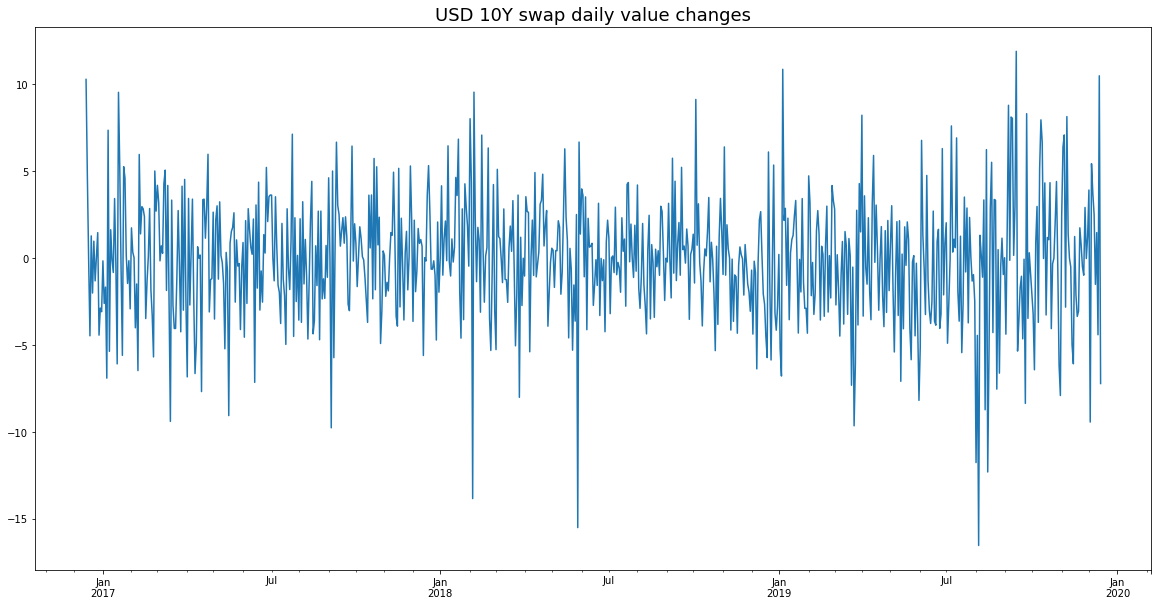

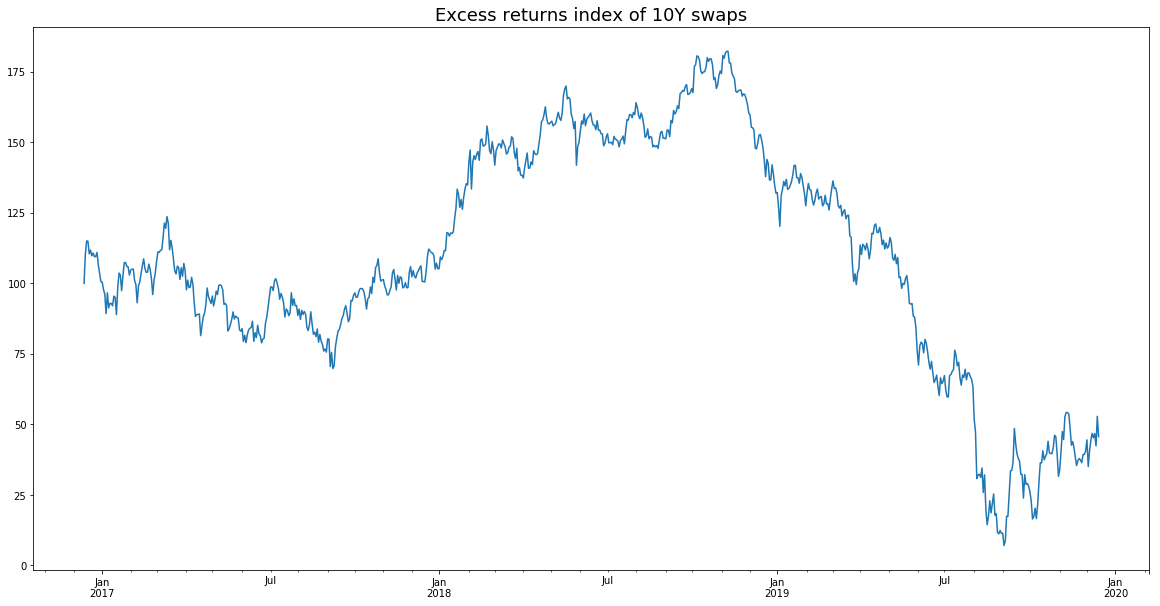

In [6]:
float_leg_dfs = []
fixed_leg_dfs = []
for t, dfs in disc_factors.iterrows():
    float_leg_dfs.append(np.interp(maturity, dfs.index, dfs.values))
    fixed_leg_dfs.append(np.interp(pay_dates, dfs.index, dfs.values))

float_leg_dfs = pd.Series(index=disc_factors.index, data=float_leg_dfs)
fixed_leg_dfs = pd.DataFrame(index=disc_factors.index, data=fixed_leg_dfs, columns=pay_dates)

fixed_leg_pv = N * 0.5 * fixed_leg_dfs.sum(axis=1) * ten_y_swap_rates.iloc[:,0]/100
float_leg_pv = N * float_leg_dfs
pv01 = N * 0.5 * fixed_leg_dfs.sum(axis=1) * 0.0001
rate_changes = ten_y_swap_rates.diff(1).iloc[:,0]/100
value_changes = pv01 * rate_changes
value_changes.plot(figsize=(20,10))
plt.title('USD 10Y swap daily value changes' ,fontsize=18)
plt.show()
value_changes.iloc[0] = 100
er_index = value_changes.cumsum()
er_index.plot(figsize=(20,10))
plt.title('Excess returns index of 10Y swaps',fontsize=18)
plt.show()

### Exercises

#### Beginners

Create a function that calculates the excess returns index for receiver position in a USD swap using the PV01 approximation taking as input the tenor of the swap.

#### Beginners

Calculate the one year carry of a swap. The carry of a swap is change in value of a swap as percentage of the notional if the receiver position is held for 1 year and neither the swap curve nor the zero coupon have changed. 

#### Intermediate

Create a swap tracker class that calculates the excess returns index for payer position in a USD swap using the PV01 approximation taking as input the tenor of the swap as one of its methods, having multiple attributes such as PV01.

#### Advanced

Create a swap tracker class that calculates the excess returns index for payer position in a USD swap using the PV01 approximation taking as input the tenor of the swap as one of its methods, having multiple attributes such as PV01 for multiple curve rates  (e.g., AUD, CAD, CHF, EUR, GBP, JPY, NZD, SEK)

#### Master

After carrying out the Advanced task above, go to [FinanceHub's Rates Tracker Class](https://github.com/Finance-Hub/FinanceHub/tree/master/trackers/Rates) and try to make a contribution!